In [22]:
# fix seed

split_seed = 1234

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

df = pd.read_csv('train.csv') 
print(df.head())
print("data num:", len(df))
#print(df.loc[:, ['label', 'pixel0'])
df_sb = pd.read_csv('test.csv')

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

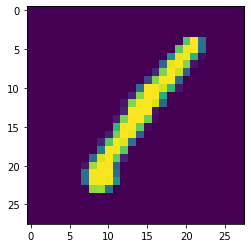

In [24]:
from sklearn.preprocessing import MinMaxScaler

df_X = df.loc[:, df.columns!='label']
df_y = df['label']

np_X = np.array(df_X).reshape(-1, 1, 28, 28)
np_y = np.array(df_y).reshape(-1, )

plt.imshow(np_X[0][0])
plt.show()

#from PIL import Image
#im = Image.fromarray(np_X[0].astype(np.uint8))
#im.save("sample_image.png")

In [25]:
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

train_X, test_X, train_y, test_y = train_test_split(np_X, np_y, test_size = 0.1, random_state = split_seed)

train_X = torch.tensor(train_X, dtype = torch.float32)
train_y = torch.tensor(train_y, dtype = torch.int64)
test_X = torch.tensor(test_X, dtype = torch.float32)
test_y = torch.tensor(test_y, dtype = torch.int64)

print(train_X.shape)
print(train_y.shape)

torch.Size([37800, 1, 28, 28])
torch.Size([37800])


In [26]:
train_set = TensorDataset(train_X, train_y)
test_set = TensorDataset(test_X, test_y)

In [27]:
# FlattenLayer(nn.Module):

class FlattenLayer(nn.Module):
    def forward(self, x):
        sizes = x.size()
        return x.view(sizes[0], -1)

In [28]:
conv_net = nn.Sequential(
    nn.Conv2d(1, 32, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Dropout2d(0.25),
    nn.Conv2d(32, 64, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Dropout2d(0.25),
    FlattenLayer()
)

test_input = torch.ones(1, 1, 28, 28)
conv_output_size = conv_net(test_input).size()[-1]
print("conv_output_size : ", conv_output_size)

mlp = nn.Sequential(
    nn.Linear(conv_output_size, 200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Dropout(0.25),
    nn.Linear(200, 10)
)

net = nn.Sequential(
    conv_net,
    mlp
)

conv_output_size :  1024


In [29]:
from tqdm import tqdm

def train_net(net, train_loader, test_loader, 
              optimizer,
              loss_fn=nn.CrossEntropyLoss(),
              n_iter = 10, device="cpu"):
    
    if not torch.cuda.is_available():
        deivce = "cpu"
        
    print("deivce : ", device)
    net.to(device)
    
    # train
    ttt = []
    train_losses = []
    train_acc = []
    test_losses = []
    test_acc = []
    
    for epoch in tqdm(range(n_iter)):
        # train data set
        net.train()
        trn = 0
        trn_loss = 0.0
        trn_acc = 0.0
        
        for i , (xx, yy) in enumerate(train_loader):
            trn += len(xx)
            xx = xx.to(device)
            yy = yy.to(device)

            h = net(xx)
            loss = loss_fn(h, yy)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_item = loss.item()
            ttt.append(loss_item)
            trn_loss += loss_item
            
            _, y_pred =  h.max(1)
            trn_acc += (yy == y_pred).float().sum().item()
        
        train_losses.append(trn_loss/i)
        train_acc.append(trn_acc/trn)
        

        # test_data set
        net.eval()
        ten = 0
        ten_loss = 0.0
        ten_acc = 0.0
                           
        for i , (xx, yy) in enumerate(test_loader):
            ten += len(xx)
            xx = xx.to(device)
            yy = yy.to(device)
            
            with torch.no_grad():            
                h = net(xx)
                loss = loss_fn(h, yy)

            ten_loss += loss.item()
                           
            _, y_pred =  h.max(1)
            ten_acc += (yy == y_pred).float().sum().item()

        test_losses.append(ten_loss/i)
        test_acc.append(ten_acc/ten)

    return ttt, train_losses, train_acc, test_losses, test_acc

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

deivce :  cuda


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.95s/it]

losses   :  0.23012549715527034
accuracy :  0.9801322751322751
test losses   :  0.18473922833800316
test accuracy :  0.985


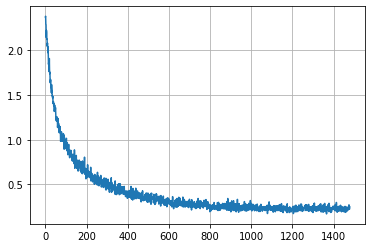

In [30]:
    batch_size = 128
    train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = True)
    
    lr = 1e-4
    weight_decay = 0.1
    optimizer = optim.Adam(net.parameters(), lr = lr, weight_decay = weight_decay)
    
    ttt, train_losses, train_acc, test_losses, test_acc = train_net(net, train_loader, test_loader, optimizer, n_iter = 5, device = 'cuda')
    
    print("losses   : ", train_losses[-1])
    print("accuracy : ", train_acc[-1])

    print("test losses   : ", test_losses[-1])
    print("test accuracy : ", test_acc[-1])

    plt.plot(list(range(len(ttt))), ttt)
    plt.grid()
    plt.show()

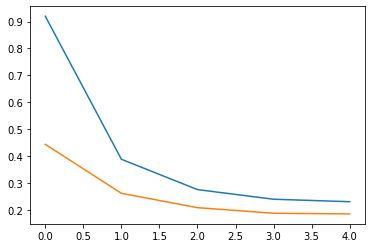

In [31]:
plt.plot(list(range(5)), train_losses, list(range(5)), test_losses)
plt.show()

In [46]:
print(df_sb.head())
np_X_sb = np.array(df_sb).reshape(-1, 1, 28, 28)
sb_X = torch.tensor(np_X_sb, dtype = torch.float32)
print(sb_X.shape)

sb_set = TensorDataset(sb_X, torch.zeros(sb_X.shape[0], ))
sb_loader = DataLoader(sb_set, batch_size = batch_size, shuffle = False)

device = 'cuda'
pred_list=[]
acc = 0.0
n = 0
for i , (xx, yy) in enumerate(sb_loader):
    n += len(xx)
    xx = xx.to(device)
    yy = yy.to(device)

    with torch.no_grad():            
        h = net(xx)

    _, y_pred =  h.max(1)
    pred_list.extend(y_pred.tolist())

sb_string ="ImageId,Label" 
for i, p in enumerate(pred_list):
    sb_string += "\n"+str(i+1)+","+str(p)

with open('dr_submission.csv', 'w') as f:
    f.write(sb_string)
    
print("\n===============\n save submission file !")

   pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0   